In [1]:
import tensorflow as tf
import numpy as np
import os
import re
from tensorflow.contrib import rnn

In [21]:
i = 1
gt = np.load('g{0}.npy'.format(i))
costs = np.load('b{0}.npy'.format(i))
acosts = np.load('a{0}.npy'.format(i))

max_disp = int(costs.shape[-1])
image_width = costs.shape[1]
image_height = costs.shape[0]
data_size = costs.shape[0]*costs.shape[1]
mask = np.ones_like(gt)
mask[np.where(gt < 0)] = 0
print gt.shape

(497, 741)


In [22]:
labels = (np.round(gt)).astype(np.int)
costs = -costs + costs.mean()
acosts = -acosts + acosts.mean()

In [23]:
costs.shape, labels.max(), gt.max()

((497, 741, 70), 63, 62.87735)

In [33]:
tf.reset_default_graph()
global_step = tf.Variable(0, trainable=False)
starter_learning_rate = 1e-4
internal_size = 6
kernel_size = 25
cost_funcs = 1
learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step,
                                           15000, 0.1, staircase=True)

W1 = tf.get_variable("W1", shape=[kernel_size,cost_funcs,internal_size], initializer=tf.contrib.layers.xavier_initializer()) 
W2 = tf.get_variable("W2", shape=[kernel_size,internal_size,2*internal_size], initializer=tf.contrib.layers.xavier_initializer()) 
W3 = tf.get_variable("W3", shape=[kernel_size,3*internal_size,1], initializer=tf.contrib.layers.xavier_initializer()) 

b1 = tf.Variable(tf.constant(0.1, shape=[internal_size]))
b2 = tf.Variable(tf.constant(0.1, shape=[2*internal_size]))
b3 = tf.Variable(tf.constant(0.1, shape=[1]))

x = tf.placeholder(tf.float32)
y_ = tf.placeholder(tf.int64, shape=[None])
valid_bits = tf.placeholder(tf.bool, shape=[None])

x_image = tf.reshape(x, [tf.shape(y_)[0],-1,cost_funcs])
x_sized = x_image[:,:,0]
h_conv2 = tf.nn.elu(tf.nn.conv1d(x_image, W1, stride=1, padding='SAME') + b1)
h_conv3 = tf.nn.elu(tf.nn.conv1d(h_conv2, W2, stride=1, padding='SAME') + b2)
h_conv4 = tf.nn.elu(tf.nn.conv1d(tf.concat([h_conv3,h_conv2],2), W3, stride=1, padding='SAME') + b3)

y_hat = h_conv4
y_out = tf.reshape(h_conv4, [tf.shape(y_)[0],-1]) + x_sized

correct_prediction = tf.equal(tf.argmax(y_out,1), y_)

ce = tf.losses.sparse_softmax_cross_entropy(tf.boolean_mask(y_,valid_bits),logits=tf.boolean_mask(y_out,valid_bits))
cross_entropy = tf.reduce_mean(ce)

train_step = tf.train.AdamOptimizer(learning_rate).minimize(cross_entropy,global_step=global_step)
#train_step = tf.train.MomentumOptimizer(learning_rate,0.9,use_nesterov=True).minimize(cross_entropy,global_step=global_step)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [ ]:
costs = np.reshape(costs,[data_size,-1])
acosts = np.reshape(acosts,[data_size,-1])

mask = np.reshape(mask,[data_size])
labels = np.reshape(labels,[data_size])
shuffle_idx = np.array([i for i in np.arange(data_size) if mask[i] == 1])
np.random.shuffle(shuffle_idx)
batch_size = 128
epoch_train = 10

In [ ]:
sess = tf.Session()

sess.run(tf.global_variables_initializer())
for i in xrange(image_height*epoch_train*image_width/(batch_size)):
    if i%(image_height*image_width/batch_size) == 0:
        loss_s = 0.0
        acc_s = 0.0
        ba_s = 0.0
        n_s = 0
    start_idx = (i*batch_size)%data_size
    end_idx = start_idx+batch_size
    idx = shuffle_idx[start_idx:end_idx]
    xb = costs[idx,:]
    ab = acosts[idx,:]
    mb = mask[idx]
    lb = labels[idx]

    if xb.shape[0] == 0:
        continue
    #feed_dict={x: np.stack([xb,ab],-1), y_: lb, valid_bits: mb}
    feed_dict={x: xb, y_: lb, valid_bits: mb}
    _,loss,acc,lr = sess.run([train_step,cross_entropy,accuracy,learning_rate], feed_dict=feed_dict)
    baseline= float((np.argmax(xb,1) == lb).sum())/lb.shape[0]
    loss_s += loss
    acc_s += acc
    ba_s += baseline
    n_s +=1 
    if i%(200)== 0:
        #print np.argmax(xb,1)
        #print lb
        print("step {0}, accuracy {1:.3g} ({4:.3g}), loss {3:.5g} lr {2:.4g}".format(i, acc_s/n_s,lr,loss_s/n_s,ba_s/n_s))

step 0, accuracy 0.688 (0.703), loss 13.814 lr 0.0001
step 200, accuracy 0.708 (0.708), loss 18.257 lr 0.0001


In [18]:
result = np.zeros((data_size,))
result_d = np.zeros((data_size,))
batch_size = data_size/20
for i in xrange(0,data_size/batch_size):
    start_idx = (i*batch_size)
    end_idx = start_idx+batch_size
    xb = costs[start_idx:end_idx,:]
    ab = acosts[start_idx:end_idx,:]
    lb = labels[start_idx:end_idx]

    feed_dict={x: xb, y_:lb}
    ot = sess.run([y_out], feed_dict=feed_dict)[0]
    result[start_idx:end_idx] = np.argmax(ot,1)
    result_d[start_idx:end_idx] = np.argmax(xb,1)

72.0 0.0


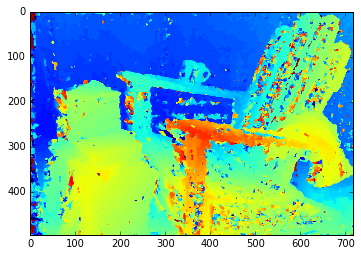

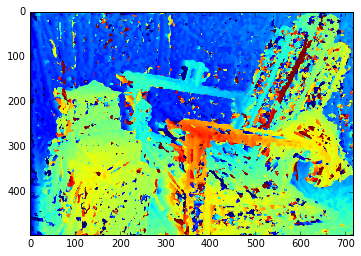

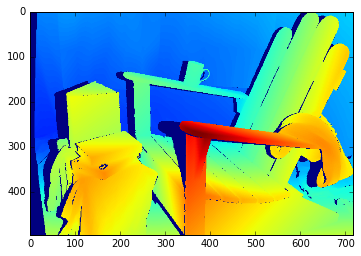

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(result.reshape(gt.shape))
print result.max(),result.min()
plt.figure()
#plt.imshow(np.argmax(costs.reshape([gt.shape[0],gt.shape[1],-1]),2))
plt.imshow(result_d.reshape(gt.shape))
plt.figure()
plt.imshow(gt)
plt.show()